In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rluser/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rluser/thesis_ws/src/ML_Levers_Knobs/DATA/1D_AUGM_KNOB_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 2000  # Example sequence length
input_shape = (WS_B, 1)

X_train_list = []
X_val_list = []
X_test_list = []

# Extract and append the data to the lists
for i in range(6):
    X_train_list.append(X_train[:,:,i])
    X_val_list.append(X_val[:,:,i])
    X_test_list.append(X_test[:,:,i])

# If you need the variables explicitly named, you can unpack them from the lists
X_train1, X_train2, X_train3, X_train4, X_train5, X_train6 = X_train_list
X_val1, X_val2, X_val3, X_val4, X_val5, X_val6 = X_val_list
X_test1, X_test2, X_test3, X_test4, X_test5, X_test6 = X_test_list

print("Shapes in X_train_list:")
for i, array in enumerate(X_train_list):
    print(f"X_train{i+1}.shape: {array.shape}")

import tensorflow as tf


2024-06-30 23:53:25.196909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-30 23:53:26.113485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-30 23:53:26.689910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 23:53:26.724170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

X_data shape: (923, 2000, 9)
y_data shape: (923,)
X_data.[0] shape:  (2000, 9)
TOTAL DATA: 923  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (553, 2000, 9)    ||  Dimensions of y_train: (553,)
Dimensions of X_test:  (185, 2000, 9)    ||  Dimensions of y_test:  (185,)
Dimensions of X_val:   (185, 2000, 9)    ||  Dimensions of y_val:   (185,)
Shapes in X_train_list:
X_train1.shape: (553, 2000)
X_train2.shape: (553, 2000)
X_train3.shape: (553, 2000)
X_train4.shape: (553, 2000)
X_train5.shape: (553, 2000)
X_train6.shape: (553, 2000)


2024-06-30 23:53:27.292540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 23:53:27.292880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 23:53:27.293115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/90


I0000 00:00:1719784413.303416   55578 service.cc:145] XLA service 0x7783500043f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719784413.303454   55578 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-06-30 23:53:33.475768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-30 23:53:34.297079: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-30 23:53:39.646128: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 5/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2856 - loss: 1.8246

I0000 00:00:1719784424.874477   55578 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2875 - loss: 1.7797

2024-06-30 23:53:51.181410: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 759ms/step - accuracy: 0.2845 - loss: 1.7758 - val_accuracy: 0.2000 - val_loss: 1.7259
Epoch 2/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2556 - loss: 1.7123 - val_accuracy: 0.3892 - val_loss: 1.6360
Epoch 3/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3447 - loss: 1.5882 - val_accuracy: 0.2216 - val_loss: 1.6774
Epoch 4/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3367 - loss: 1.4798 - val_accuracy: 0.4324 - val_loss: 1.3077
Epoch 5/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4089 - loss: 1.3594 - val_accuracy: 0.4811 - val_loss: 1.2120
Epoch 6/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4998 - loss: 1.1451 - val_accuracy: 0.4757 - val_loss: 1.2196
Epoch 7/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5023 - loss: 1.1343 - val_accuracy: 0.6108 - val_loss: 0.9929
Epoch 8/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6162 - loss: 0.9258 - val_accuracy: 0.5459 - val_loss: 

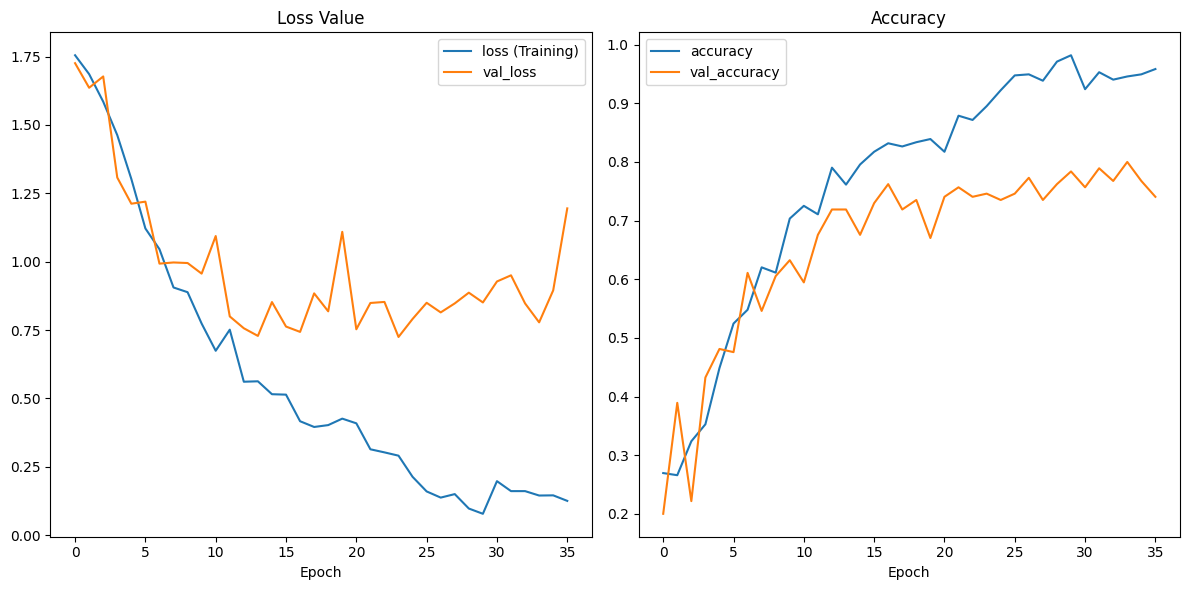

Test loss: 0.7160966396331787
Test accuracy: 0.7945945945945946
F1 Score: 0.8016315687656318
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        42
         1.0       0.76      0.81      0.79        48
         2.0       0.70      0.74      0.72        42
         3.0       1.00      0.85      0.92        13
         4.0       0.88      0.78      0.82        18
         5.0       0.70      0.64      0.67        22

    accuracy                           0.79       185
   macro avg       0.82      0.79      0.80       185
weighted avg       0.80      0.79      0.79       185



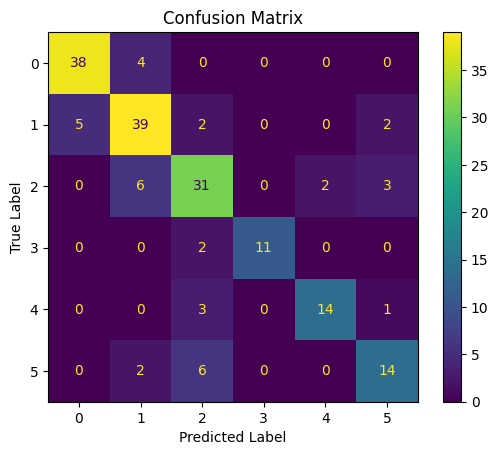

In [2]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_0')(input_layer)
        x = Conv1D(filters=128, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [(WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1)]
model = build_branched_model(input_shapes)
#model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(
    [X_train1, X_train2, X_train3, X_train4, X_train5, X_train6], 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_data=([X_val1, X_val2, X_val3, X_val4, X_val5, X_val6], y_val), 
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

# Calculate F1 score and accuracy
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [3]:
# model_name = "ALL_KNOB_6Branches_%"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Epoch 1/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.2416 - loss: 1.7531 - val_accuracy: 0.3027 - val_loss: 1.8196
Epoch 2/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3319 - loss: 1.5749 - val_accuracy: 0.3514 - val_loss: 1.4515
Epoch 3/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4366 - loss: 1.3654 - val_accuracy: 0.5189 - val_loss: 1.2656
Epoch 4/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4880 - loss: 1.2622 - val_accuracy: 0.2865 - val_loss: 1.6294
Epoch 5/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4602 - loss: 1.3217 - val_accuracy: 0.4973 - val_loss: 1.2737
Epoch 6/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5181 - loss: 1.1584 - val_accuracy: 0.5459 - val_loss: 1.1488
Epoch 7/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5906 - loss: 1.0478 - val_accuracy: 0.5351 - val_loss: 1.1314
Epoch 8/90
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5355 - loss: 1.0442 - val_accuracy: 0.5946 - val_los

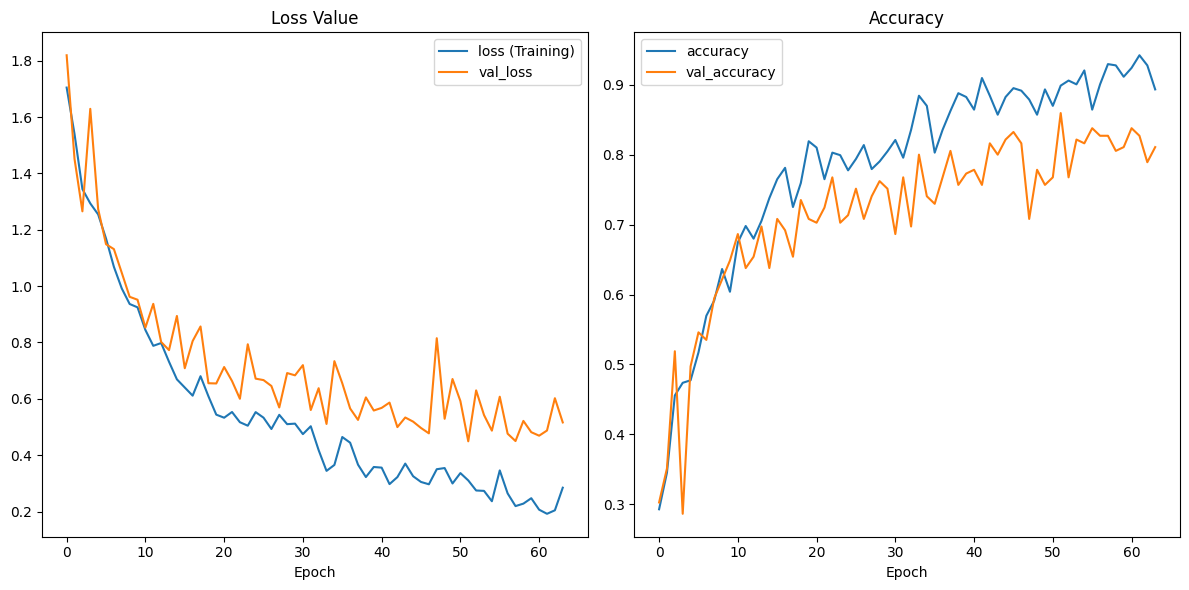

Test loss: 0.5529066920280457
Test accuracy: 0.827027027027027
F1 Score: 0.8367246391735653
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.95      0.87        42
         1.0       0.86      0.62      0.72        48
         2.0       0.90      0.88      0.89        42
         3.0       1.00      0.85      0.92        13
         4.0       0.89      0.89      0.89        18
         5.0       0.63      0.86      0.73        22

    accuracy                           0.83       185
   macro avg       0.85      0.84      0.84       185
weighted avg       0.84      0.83      0.83       185



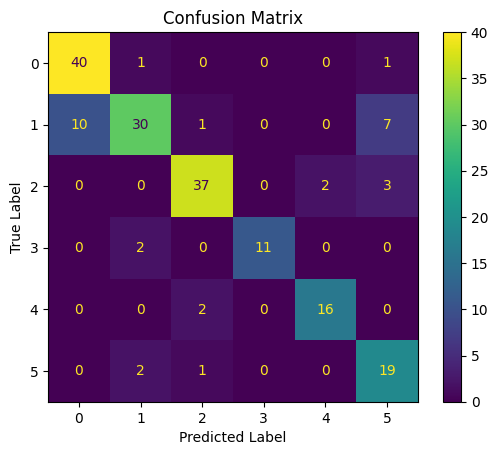

In [4]:
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=256, kernel_size=100, strides=20, activation='relu', padding='same', name=f'conv1d_{branch_id}_0')(input_layer)
        #x = Conv1D(filters=128, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_1')(x)
        #x = Conv1D(filters=256, kernel_size=4, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        # x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        # x = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [(WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1), (WS_B, 1)]
model = build_branched_model(input_shapes)
#model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
history = model.fit(
    [X_train1, X_train2, X_train3, X_train4, X_train5, X_train6], 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_data=([X_val1, X_val2, X_val3, X_val4, X_val5, X_val6], y_val), 
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6], y_test)

# Predict labels for test data
y_pred = model.predict([X_test1, X_test2, X_test3, X_test4, X_test5, X_test6])
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot training history
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.tight_layout()
plt.show()

# Calculate F1 score and accuracy
f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("F1 Score:", f1)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[0, 1, 2, 3, 4, 5])
disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()